<div dir="rtl">
<b>فصل دوم - کلاس بندی</b>
<br>
<i>توی این فصل درباره مسئله کلاس بندی صحبت میکنیم و با mnist کار رو پیش میبریم.</i>

<h4> انواع پکیچ ها و کاربردهای ان </h4>

</div>



In [1]:
# Python ≥3.5 is required
import sys
# بررسی اینکه نسخه پایتون حداقل ۳.۵ است
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# یکی از معروف ترین کتابخانه های یادگیری ماشین در پایتون

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
# کتابخانه کار با اعداد
import numpy as np
# کتابخانه رابط پایتون و موارد مربوط به سیستم عامل
import os

# to make this notebook's output stable across runs
# سید برای اعداد رندوم تا شبیه خروجی در راستای خاصی باشند 
np.random.seed(42)

# To plot pretty figures
# موارد لازم برای رسم و ذخیره کردن نمودارها
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
# محل ذخیره سازی نمودار


PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
# تابع ذخیره سازی نمودار 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
# برای اینکه اگر به خطای خاصی برخورد کردیم نادیدش بگیریم
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="^")

<div dir="rtl">
    <h2>دیتاست MNIST</h2>
    در واقع mnist یک دیتاست خالی نسبت بلکه سری از دیتاست هاست که در اینجا از نسخه دست خط هاش استفاده میکنیم
    <br>
    <hr>
    برای استفاده از این دیتاست روش های مختلفی هست که یکی از اون ابزار درون ساختی sklearn هست که میتونیم از openml یک دیتاست خاص رو دانلود کنه.
</div>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

<div dir="rtl">
جدا کردن بخش ویژگی های مورد نیاز برای آموزش و ویژگی های پیش بینی
</div>

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

<div dir="rtl">
نمایش داده ها به صورت عکس های  ۲۸ در ۲۸ 

</div>

Saving figure some_digit_plot
 Y : 5


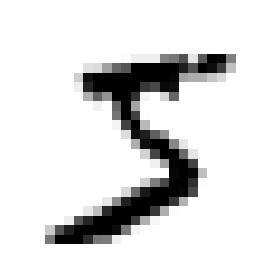

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
print(" Y : " + y[0])
plt.show()

<div dir="rtl">
یک نکته قابل توجه برای ما این هست که همیشه باید حواسمون به نوع داده ها باشه مثلا در خروجی ۵ عدد هست یا استرینگ؟
</div>

In [6]:
type(y[0])

str

<div dir="rtl">
با توجه به اینکه رشته هست ما باید نوع داده ای رو به عدد تغییر بدیم و با توجه به اینکه اعداد رنج مشخصی دارند int گزینه خوبی است
</div>

In [7]:
y = y.astype(np.uint8)

<div dir="rtl">
<h4> رسم اعداد </h4>
</div>

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

<div dir="rtl">
نسخه پیشرفته تر از تابع بالا و رسم اعداد کنار هم
</div>

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


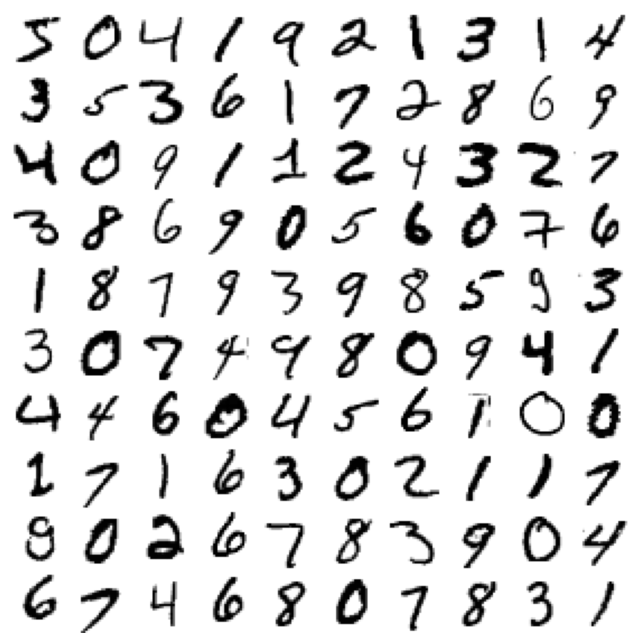

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

<div dir="rtl">
تقسیم بندی داده ها به دسته آموزش و تست و اعتبار سنجی
<br>
   توجه داشته باشید که راه حل استفاده از ایندکس های تصادفی گزینه بهتری هست و باعث حفظ توزیع داده ها میشود.

</div>

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<div dir="rtl">
<h4>دسته بندی دودویی</h4>
<hr>
دسته بندی دودویی به تعریف ساده هست یا نیست رو مشخص میکنه
   
</div>


In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


<div dir="rtl">
بررسی یک نمونه که قبلا نشون دادیم و ۵ بود
<br>
</div>

In [14]:
sgd_clf.predict([some_digit])

array([ True])


<div dir="rtl">
حالا بیایم و بررسی کنیم به صورت دقیق تر وضعیت به چه شکل است با کمک کراس ولیدیشن<br>
</div>

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])


<div dir="rtl">
همانطور که میبینید در سه بار تلاش دسته بندی دودویی ما بالای ۹۵ درصد دقت داشته
<br>
    حالا با کمک Kold آموزش رو انجام میدیم
</div>

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.95035
0.96035
0.9604



<div dir="rtl">
خب الان این دقت به معنای یک دقت خوب هست؟ نه لزوما بیایم یک ایده رو طراحی کنیم مدلی که هر وقت پرسیدم ۵ هست بگه نه!
<br>
</div>

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])



<div dir="rtl">
خب الان دقت ۹۰ درصد خوب هست یعنی؟ نه لزوما همانطور که قابل مشاهده هست ما هیچ آموزشی انجام نمیدیم و فقط میگیم هر چیزی دریافت کرد مدل بذاره بگه ۵ نیست.
<br>
از طرفی در هر حالتی احتمال ۵ بودن هم ۱/۱۰ و اینجا بدون یادگیری  با داده های بالانس میتونیم دقت ۹۰ درصد رو بگیریم

<br>
اما یک جای کار میلنگه برای جلوگیری از همچین اتفاق هایی ما از ماتریس Confusion که به صورت دقیق بگه وضعیت چطوری هست.

</div>
<img src="images/classification/confusion_matrix.png"/>

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

<div dir="rtl">
شاید بهتر باشه نتیجه این بخش رو به عنوان تمرین تحیلی مدل داشته باشید
    <h4>  معیار هایی که برای بررسی بهتر  confusion matrix داریم   </h4>
</div>
<img src="images/classification/Precisionrecall.png"/>

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311


<div dir="rtl">
معیار دیگه هم هست که کامل تر نسبت به دوتای قبلی هست با فرمول
   
</div>
<img src="images/classification/F1_Score.png"/>

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846



<div dir="rtl">
در ادامه درباره تغییرات استانه - threshold هست و روی مدل ببینم به چه شکل عمل میکنه
   
</div>

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [27]:
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


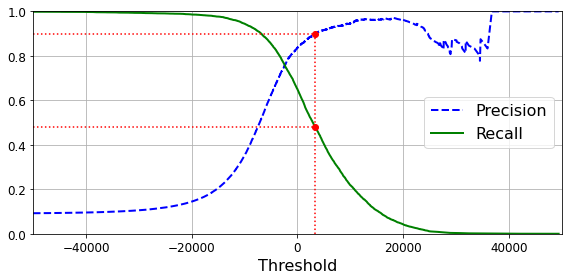

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [32]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


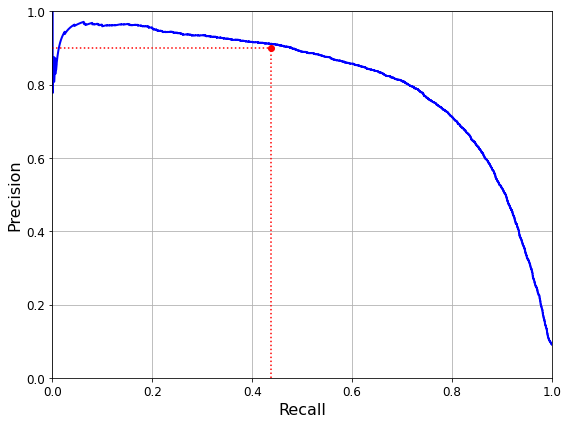

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [35]:
threshold_90_precision

3370.0194991439557

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706



<div dir="rtl">
    <h3> منحنی ROC </h3>   
</div>

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


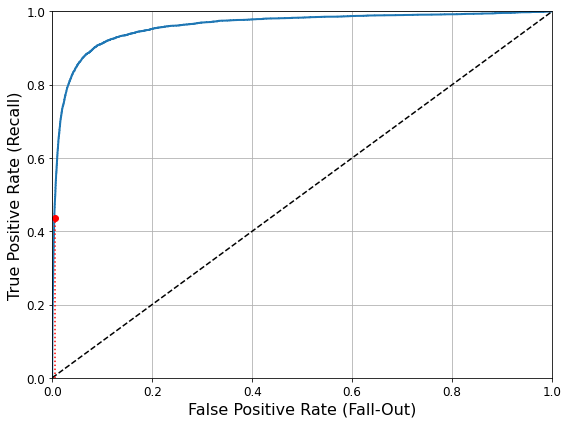

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [43]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


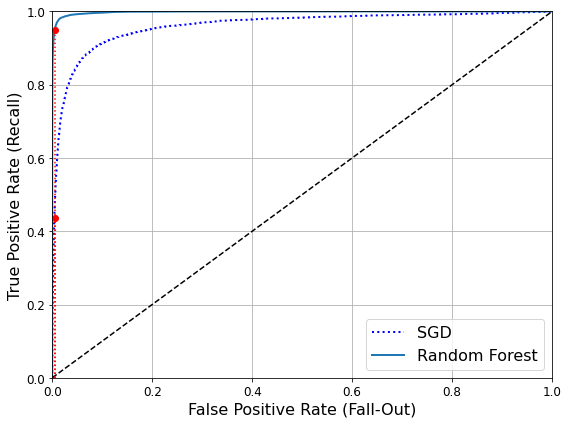

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

<div dir="rtl">
    <h3>دسته بندی چند دسته ای </h3> 
    کلاسیک ترین حالت ممکنه یک الگوریتم نظارت شده دسته بندی اون هست که باید بگیم یک نمونه عضو کدوم دسته هست.
    <hr>
    <br>
    
    ابتدا میایم از svm نسخه دسته بندیش استفاده میکنیم
</div>

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])


array([5], dtype=uint8)

<div dir="rtl">
   احتمالات اینکه این نسخه ( عدد ۵ ) عضو کدوم دسته باشه
    </div>

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

<div dir="rtl">و بیشینه احتمال    </div>

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [73]:
svm_clf.classes_[5]

5

In [52]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [59]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


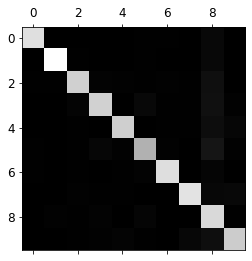

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


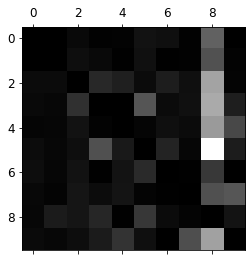

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


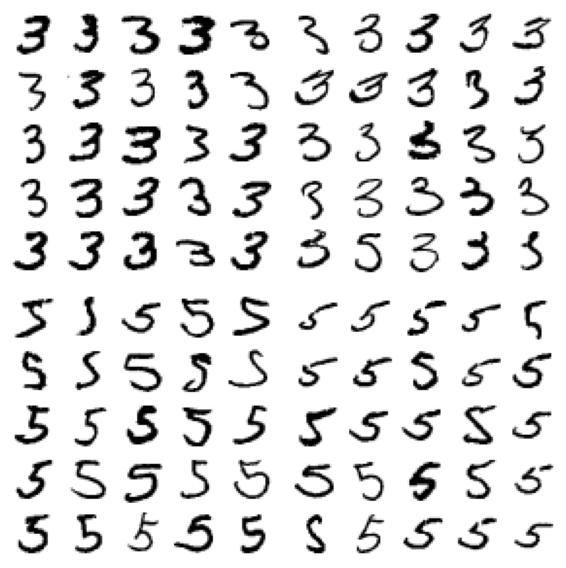

In [63]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

<div dir="rtl">
    <h3>دسته بندی مولتی لیبل</h3>  
    حالت الگوریتم های دسته بندی به شیوه مولتی لیبل هست که بگیم در یک زمان یک نمونه عضو کدوم دسته ها هست.
</div>

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

<div dir="rtl">
   این تیکه کد ممکنه تا ساعت ها طول بکشه پس حواستون باشه به اجراش

</div>

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

<div dir="rtl">
    <h3>دسته بندی چندین خروجیه</h3>  
 میشه گفت حالت رگرسیون مولتی لیبل هست
</div>


In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


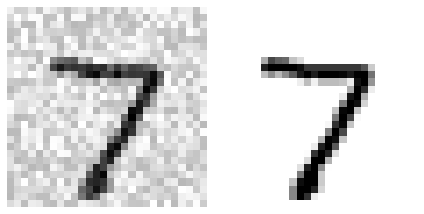

In [70]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


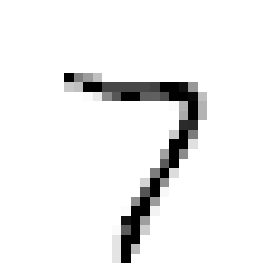

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")